# Notebook 3 – First baseline model

Purpose:
- Load truth data from Hopsworks feature store.
- Define feature set and train the first baseline model.
- Run predictions on a holdout set and evaluate (e.g., MAE/MSE).
- Log model version and metrics (Hopsworks/MLflow/file).
- Persist the trained model so Notebook 4 can load it.

Notes:
- Document chosen model type (e.g., XGBoost, RandomForest, LSTM) and tested hyperparameters.
- Record performance and next experiments to try.


In [1]:
from pathlib import Path
import os
import sys
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import json
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
import hopsworks

# 1. Find project root (one level up from notebooks/)
root_dir = Path("..").resolve()

# 2. Add project root to PYTHONPATH so we can import the src package
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

# 3. Load .env from project root
env_path = root_dir / ".env"
load_dotenv(env_path)

# 4. Load settings and utility functions (after adjusting PYTHONPATH)
from src.config import ElectricitySettings
from src import util

settings = ElectricitySettings()

# 5. Log in to Hopsworks and get feature store
project = hopsworks.login(engine="python")
fs = project.get_feature_store()

print("Successfully logged in to Hopsworks project:", settings.HOPSWORKS_PROJECT)


ElectricitySettings initialized
2025-12-12 21:39:31,649 INFO: Initializing external client
2025-12-12 21:39:31,649 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2025-12-12 21:39:32,654 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/127
Successfully logged in to Hopsworks project: ScalableProject


In [2]:
secrets = hopsworks.get_secrets_api()
area = secrets.get_secret("ELECTRICITY_LOCATION_JSON").value
area = json.loads(area)
PRICE_AREA = area['price_area']
CITY = area['city']
LATITUDE = area['latitude']
LONGITUDE = area['longitude']

In [3]:
# Get the feature groups (schema with engineered features)
electricity_prices_fg = fs.get_feature_group('electricity_prices', version=1)
weather_hourly_fg = fs.get_feature_group('weather_hourly', version=1)

In [4]:
# Select features for training data and join on primary key (price_area, unix_time)
price_feats = electricity_prices_fg.select([
    "price_area",
    "unix_time",
    "price_sek",
    "weekday",
    "is_weekend",
    "month",
    "season",
    "is_holiday",
    "price_lag_24",
    "price_lag_48",
    "price_lag_72",
    "price_roll3d",
])

weather_feats = weather_hourly_fg.select([
    "price_area",
    "unix_time",
    "date",
    "hour",
    "temperature_2m", "apparent_temperature",
    "precipitation", "rain", "snowfall",
    "cloud_cover",
    "wind_speed_10m", "wind_speed_100m",
    "wind_direction_10m", "wind_direction_100m",
    "wind_gusts_10m",
    "surface_pressure",
])

# Filter to target price area
price_feats = price_feats.filter(electricity_prices_fg["price_area"] == PRICE_AREA.lower())
weather_feats = weather_feats.filter(weather_hourly_fg["price_area"] == PRICE_AREA.lower())

# Join on PK
features = weather_feats.join(price_feats, on=["price_area", "unix_time"])





In [5]:
feature_view = fs.get_or_create_feature_view(
    name=f"electricity_prices_fv_{PRICE_AREA.lower()}",
    description=f"weather + electricity prices features for {PRICE_AREA} (with calendar, holiday, lags)",
    version=1,
    labels=["price_sek"],
    query=features,
)



In [6]:
df = feature_view.get_batch_data().sort_values("date")
t_min, t_max = df["date"].min(), df["date"].max()
test_start = t_min + (t_max - t_min) * 0.8  # 80 % första delen blir train

# 2) Låt feature view göra splitten
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.09s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.69s) 
2025-12-12 21:39:54,048 INFO: Computing insert statistics
2025-12-12 21:39:54,089 INFO: Computing insert statistics
2025-12-12 21:39:55,389 WARNING: VersionWarning: Incremented version to `2`.



In [7]:
X_train

,price_area,unix_time,date,hour,temperature_2m,apparent_temperature,precipitation,rain,snowfall,cloud_cover,...,electricity_prices_unix_time,electricity_prices_weekday,electricity_prices_is_weekend,electricity_prices_month,electricity_prices_season,electricity_prices_is_holiday,electricity_prices_price_lag_24,electricity_prices_price_lag_48,electricity_prices_price_lag_72,electricity_prices_price_roll3d
0,se3,1667523600000,2022-11-04 01:00:00,1,7.721500,4.971277,0.0,0.0,0.0,84.0,...,1667523600000,4,0,11,3,0,0.31909,0.18971,0.38430,0.596917
1,se3,1667530800000,2022-11-04 03:00:00,3,7.321500,4.676466,0.0,0.0,0.0,100.0,...,1667530800000,4,0,11,3,0,0.33950,0.22049,0.41173,0.591142
2,se3,1667588400000,2022-11-04 19:00:00,19,8.221499,4.513697,0.0,0.0,0.0,100.0,...,1667588400000,4,0,11,3,0,0.36743,0.76387,0.89431,0.486108
3,se3,1667642400000,2022-11-05 10:00:00,10,8.421500,4.657833,0.3,0.3,0.0,100.0,...,1667642400000,5,1,11,3,1,0.37179,0.41872,0.46478,0.477426
4,se3,1667746800000,2022-11-06 15:00:00,15,8.871500,5.454870,0.0,0.0,0.0,100.0,...,1667746800000,6,1,11,3,1,0.61532,0.31233,0.87204,0.372557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26874,se3,1745823600000,2025-04-28 07:00:00,7,10.671500,7.090998,0.0,0.0,0.0,100.0,...,1745823600000,0,0,4,1,0,0.01557,0.26744,0.57133,0.304170
26875,se3,1745906400000,2025-04-29 06:00:00,6,11.171500,7.798737,0.0,0.0,0.0,6.0,...,1745906400000,1,0,4,1,0,0.53437,0.22800,0.44335,0.242793
26876,se3,1745924400000,2025-04-29 11:00:00,11,14.571500,10.590017,0.0,0.0,0.0,88.0,...,1745924400000,1,0,4,1,0,-0.03214,-0.16153,-0.01336,0.245187
26877,se3,1745949600000,2025-04-29 18:00:00,18,13.371500,12.165705,0.0,0.0,0.0,53.0,...,1745949600000,1,0,4,1,0,0.35606,0.58738,0.53798,0.264834


In [8]:
cat_cols = [c for c in X_train.columns if 'price_area' in c]
X_features = X_train.drop(columns=['date'] + cat_cols)
X_test_features = X_test.drop(columns=['date'] + cat_cols)

In [9]:
y_train

,electricity_prices_price_sek
0,0.19089
1,0.19661
2,0.29101
3,0.62170
4,0.42555
...,...
26874,0.39899
26875,0.57937
26876,-0.00428
26877,1.51119


In [10]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=800,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    n_jobs=-1,
)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(
    X_features, y_train,
    eval_set=[(X_test_features, y_test.iloc[:,0])],
    verbose=False,
    early_stopping_rounds=50,
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

2025-12-12 21:39:57,153 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-12 21:39:57,153 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

MSE: 0.088955835
2025-12-12 21:39:57,155 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-12 21:39:57,155 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

R squared: 0.5671620749499742


In [12]:
df = y_test
df['predicted_price_sek'] = y_pred
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5433 entries, 1347 to 27226
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   electricity_prices_price_sek  5433 non-null   float32
 1   predicted_price_sek           5433 non-null   float32
dtypes: float32(2)
memory usage: 84.9 KB


In [13]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,electricity_prices_price_sek,predicted_price_sek,date
26879,0.37168,0.160825,2025-04-29 23:00:00
18346,0.36543,0.141121,2025-04-30 00:00:00
21800,0.36674,0.134789,2025-04-30 01:00:00
14916,0.35304,0.185678,2025-04-30 02:00:00
26880,0.36576,0.194321,2025-04-30 03:00:00


In [14]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "electricity_prices_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [15]:
import reload

In [16]:
import importlib
import src.util as util
importlib.reload(util)

<module 'src.util' from '/Users/jesper/Documents/KTH/Skalbar_ML/Project/src/util.py'>

2025-12-12 21:39:57,230 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



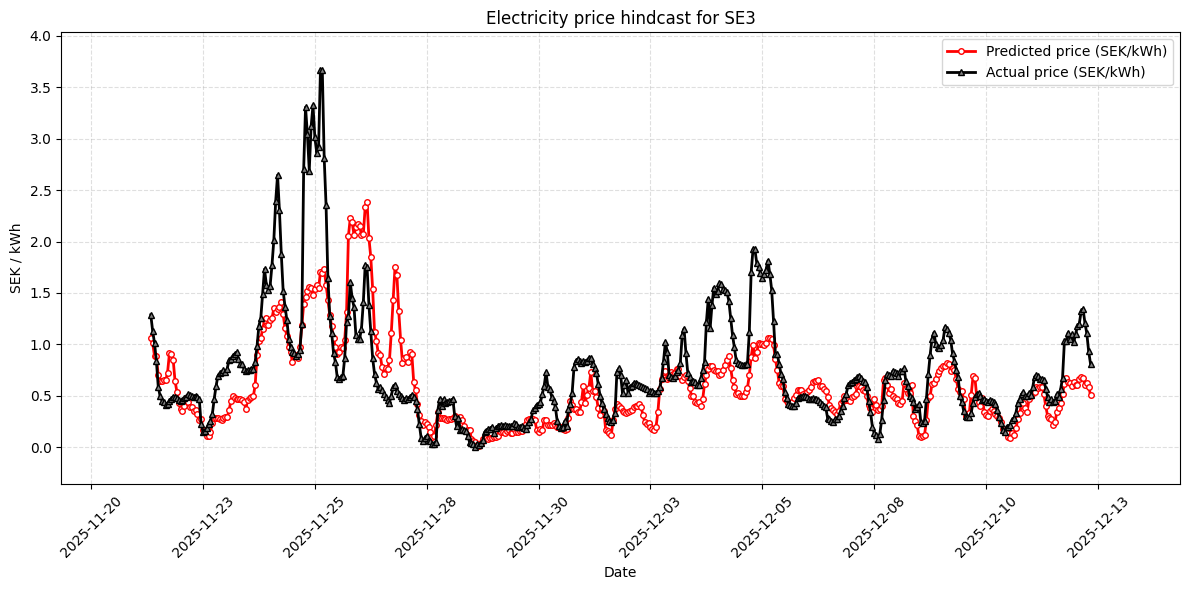

In [17]:

file_path = images_dir + "/electricity_price_hindcast.png"
plt = util.plot_electricity_price_forecast(
    PRICE_AREA,
    df,
    file_path,
    hindcast=True,
    window_days=21,
)
plt.show()

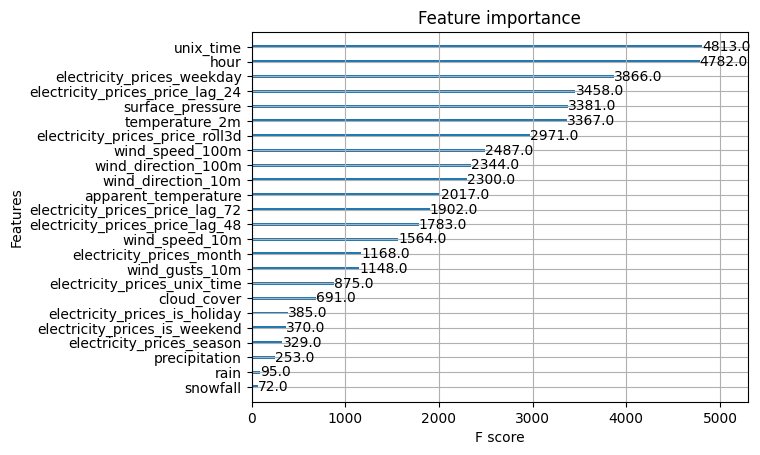

In [18]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [19]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [20]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [21]:
mr = project.get_model_registry()

# Register a per-sensor model name
model_name = f"electricity_prices_xgboost_model_lags_{PRICE_AREA.lower()}"

aq_model = mr.python.create_model(
    name=model_name, 
    metrics= res_dict,
    feature_view=feature_view,
    description=f"Electricity prices predictor with electricity price lag features for {PRICE_AREA}",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/jesper/Documents/KTH/Skalbar_ML/Project/NotebooksElectricity/electricity_prices_model/model.j…

Uploading /Users/jesper/Documents/KTH/Skalbar_ML/Project/NotebooksElectricity/electricity_prices_model/images/…

Uploading /Users/jesper/Documents/KTH/Skalbar_ML/Project/NotebooksElectricity/electricity_prices_model/images/…

Uploading /Users/jesper/Documents/KTH/Skalbar_ML/Project/NotebooksElectricity/model_schema.json: 0.000%|      …

Model created, explore it at https://eu-west.cloud.hopsworks.ai:443/p/127/models/electricity_prices_xgboost_model_lags_se3/1


Model(name: 'electricity_prices_xgboost_model_lags_se3', version: 1)

# Electricity Price Prediction - Backfill Pipeline

## 🗒️ Overview
This notebook collects historical data for electricity price prediction in Stockholm (SE3):
1. **Electricity prices** from elprisetjustnu.se API (hourly data from Nov 2022)
2. **Weather data** from Open-Meteo API (hourly historical data)

The goal is to train a model that predicts electricity prices for each hour of the next day.

### Weather Features Selected
We use weather features that affect electricity supply and demand:
- **Temperature** → heating/cooling demand
- **Wind speed** (10m & 100m) → wind power generation
- **Cloud cover** → solar power generation
- **Precipitation** → hydro power availability